In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

# Problem 1

In [2]:
data = loadmat('./data/FoCOwxSept.mat')

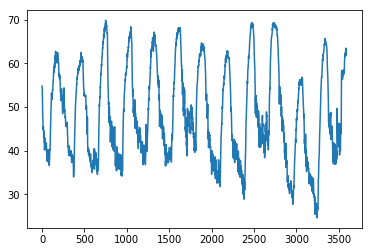

In [3]:
plt.plot(data['Temp'])

In [4]:
def get_embedding(X, T=1):
    X = np.array(X)
    res = np.zeros((X.shape[0]-3*T, 3))
    y = np.zeros((X.shape[0]-3*T))
    for i in range(3*T, res.shape[0]+3*T):
        res[i-3*T] = [X[i-T], X[i-2*T], X[i-3*T]]
        y[i-3*T] = X[i]
    return res, y

In [5]:
def plot_time_delay_embedding(embed_x):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(embed_x[:, 0], embed_x[:, 1], zs=embed_x[:, 2], marker='.')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.view_init(30, 145)
    plt.show()

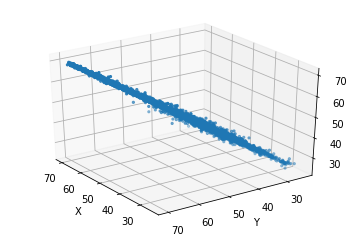

In [6]:
plot_time_delay_embedding(get_embedding(data['Temp'], 1)[0])

In [12]:
# split training, validation and testing
def get_train_val_test(data, train_val_split = 9):
    x, y = get_embedding(data['Temp'], 1)
    test_x = x[-500:, :].T
    test_y = y[-500:].reshape(1, 500)

    val_inds = np.random.choice(x.shape[0]-500, (x.shape[0]-500)//train_val_split, replace=False)
#     print(len(set(val_inds)) == len(val_inds))
    train_inds = np.setdiff1d(range(x.shape[0]-500), val_inds)
    train_x = x[train_inds, :].T
    train_y = y[train_inds].reshape(1, len(train_inds))
    val_x = x[val_inds, :].T
    val_y = y[val_inds].reshape(1, len(val_inds))
    print(train_x.shape, train_y.shape, val_x.shape, val_y.shape, test_x.shape, test_y.shape)
    return train_x, train_y, val_x, val_y, test_x, test_y

In [13]:
train_x, train_y, val_x, val_y, test_x, test_y = get_train_val_test(data, 9)

(3, 2745) (1, 2745) (3, 343) (1, 343) (3, 500) (1, 500)


# Problem 2

In [14]:
def distortion_error(X, centers, x_center_mapping):
    res = 0
    for i in range(X.shape[1]):
        res += np.linalg.norm(X[:, i] - centers[:, x_center_mapping[i]])
    return res/X.shape[1]

def LBG(X, Nc):
    n, p = X.shape
    centers = np.random.rand(n, Nc)  # randomly intialize Nc centers
    x_center_mapping = [0 for i in range(p)]
    
    e_threshold = 0.01
    for i in range(100):
        e = distortion_error(X, centers, x_center_mapping) 
        if e <= e_threshold:
            break
        voronoi_set_sum = np.zeros((n, Nc))
        voronoi_set_cnt = np.array([0 for i in range(Nc)])
        for i in range(p):
            distances = [np.linalg.norm(centers[:, k] - X[:, i]) for k in range(Nc)]
            closest_ind = np.argmin(distances)
            x_center_mapping[i] = closest_ind
            voronoi_set_sum[:, closest_ind] += X[:, i]
            voronoi_set_cnt[closest_ind] += 1
        for i in range(Nc):
            if voronoi_set_cnt[i] != 0:
                centers[:, i] = voronoi_set_sum[:, i]/voronoi_set_cnt[i]
    return centers

In [15]:
def phi(r, alpha=1, method=0):
    '''
    This defines the radial basis functions
    Method ranges from 0 to 5 (inclusive)
    '''
    if method == 0:
        return r
    elif method == 1:
        return r*r*np.log(r)
    elif method == 2:
        return r**3
    elif method == 3:
        return np.exp(-(r/alpha)**2)
    elif method == 4:
        return np.sqrt(alpha**2 + r**2)
    elif method == 5:
        return 1/np.sqrt(alpha**2 + r**2)
    else:
        raise ValueError('%s is not an acceptable RBF method' % method)

def get_centers(X, Nc, center_choice):
    if center_choice=='rand':
        center_inds = np.random.randint(X.shape[1], size=Nc)
#         print(center_inds)
        return X[:, center_inds]
    elif center_choice == 'lbg':
        return LBG(X, Nc)
    else:
        raise ValueError('%s is not a valid center_choice' % center_choice)
    
def get_PHI(X, centers, rbf_func, rbf_alpha=None):
    p = X.shape[1]
    Nc = centers.shape[1]
    PHI = np.ones((p, Nc+1))
    for i in range(p):
        for j in range(1, Nc):
            PHI[i][j] = phi(np.linalg.norm(X[:, i] - centers[:, j-1]), rbf_alpha, rbf_func)
    return PHI

def RBF_train(X, Y, Nc, center_choice, rbf_func, rbf_alpha=None):
    '''
    @:Nc: Number of centers
    '''
    X = np.array(X)
    centers = get_centers(X, Nc, center_choice)
    PHI = get_PHI(X, centers, rbf_func, rbf_alpha)
    u, s, vh = np.linalg.svd(PHI)
#     s = np.hstack((s, np.zeros(u.shape[0] - s.shape[0])))
#     print(u.shape, s.shape, vh.shape)
    tmp = np.diag(s)
    tmp = np.vstack((tmp, np.zeros((u.shape[0] - s.shape[0], vh.shape[0]))))
#     print(u.shape, tmp.shape, vh.shape)
#     print(np.linalg.pinv(tmp).shape)
    w = vh.T @ np.linalg.pinv(tmp) @ u.T @ Y.T
    
    return w, centers

def RBF_test(X_test, w, centers, Y_true, rbf_func, rbf_alpha=None):
    PHI = get_PHI(X_test, centers, rbf_func, rbf_alpha)
    y_pred = PHI @ w
    error = np.sum((y_pred - Y_true.reshape(y_pred.shape))**2) / np.sum((y_pred - np.mean(X_test, axis=0).reshape(y_pred.shape))**2)
    return y_pred, error

### Test LBG and different number of centers

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

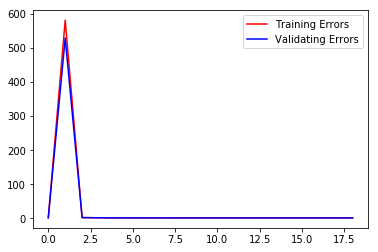

In [24]:
train_errors = []
val_errors = []

for i in range(1, 20):
    print(i, end=' ')
    w, centers = RBF_train(train_x, train_y, Nc=i, center_choice='lbg',rbf_func=0, rbf_alpha=1)
    _, t_error = RBF_test(train_x, w, centers, train_y, rbf_func=0, rbf_alpha=1)
    _, v_error = RBF_test(val_x, w, centers, val_y, rbf_func=0, rbf_alpha=1)
    train_errors.append(t_error)
    val_errors.append(v_error)

plt.plot(train_errors[:50], 'r', label='Training Errors')
plt.plot(val_errors[:50], 'b', label='Validating Errors')
plt.legend()
plt.show()

### Test different number of centers

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

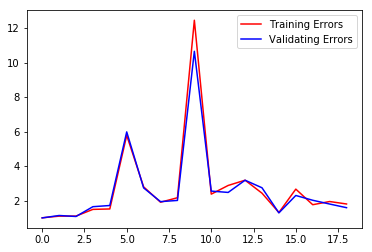

In [25]:
train_errors = []
val_errors = []

for i in range(1, 20):
    print(i, end=' ')
    w, centers = RBF_train(train_x, train_y, Nc=i, center_choice='rand',rbf_func=0, rbf_alpha=1)
    _, t_error = RBF_test(train_x, w, centers, train_y, rbf_func=0, rbf_alpha=1)
    _, v_error = RBF_test(val_x, w, centers, val_y, rbf_func=0, rbf_alpha=1)
    train_errors.append(t_error)
    val_errors.append(v_error)

plt.plot(train_errors[:50], 'r', label='Training Errors')
plt.plot(val_errors[:50], 'b', label='Validating Errors')
plt.legend()
plt.show()

### Test different RBF functions with alpha=1

In [10]:
train_errors = []
val_errors = []

for i in range(0, 5):
    print(i, end=' ')
    w, centers = RBF_train(train_x, train_y, Nc=10, center_choice='rand', rbf_func=i, rbf_alpha=1)
    _, t_error = RBF_test(train_x, w, centers, train_y, rbf_func=i, rbf_alpha=1)
    _, v_error = RBF_test(test_x, w, centers, test_y, rbf_func=i, rbf_alpha=1)
    train_errors.append(t_error)
    val_errors.append(v_error)

plt.plot(train_errors, 'r', label='Training Errors')
plt.plot(val_erros, 'b', label='Validating Errors')
plt.show()

0 

TypeError: RBF_test() missing 1 required positional argument: 'rbf_func'

# Problem 3 - neural network

Note that the input and output have to be transposed here. 

In [19]:
class MLP:
    def __init__(self, learning_rate=0.01, batch_size=1, epoch=10, layers=[3], act='tanh'):
        """
        Parameters here are training parameters
        """
        self.learning_rate=0.01
        self.batch_size=1
        self.epoch = epoch    
        self.layers = layers
        
        self.weights = []  # can only construct when trainx and trainy are supplied
        self.hidden_states_p = []
        self.hidden_states_s = []
        self.trainx = None
        self.trainy = None
    
    def _set_modes(act='tanh'):
        if act == 'tanh':
            self.act_func = lambda x: np.expm1(2*x)/(np.expm1(2*x) + 2)
            self.act_func_deriv = lambda x: 1 - (self.act_func(x)) ** 2
            self.normy_mean = 
            self.y_norm_func = lambda x: (x - np.mean(x, axis=0)[None, :])/np.amax(x - np.mean(x, axis=0)[None, :], axis=0)[None, :]
        elif act == 'relu':
            self.act_func = lambda x: x * ((x>0).astype(np.int32))
            self.act_func_deriv = self.act_func
            self.y_norm_func = lambda x: x - np.amin(x, axis=0)[None, :]
        else:
            raise ValueError('Activation %s is not recognized!' % act)
    
    def train(self, trainx, trainy):
        self.trainx, self.trainy = np.copy(trainx), np.copy(trainy)
        if len(self.trainy.shape) == 1:
            self.trainy = self.trainy.reshape(-1, 1)
        if len(self.trainx.shape) == 1:
            self.trainx = self.trainx.reshape(-1, 1)
        self.trainx = np.hstack((np.ones((self.trainx.shape[0], 1)), self.trainx))  # append ones to trainx
        self.trainy = 
        self._construct_weights()
        for e in range(self.epoch):
            inds = np.random.permutation(np.arange(self.trainx.shape[0]))
            for b in range((self.trainx.shape[0]-1) // self.batch_size + 1):
                batch_inds = inds[b*self.batch_size: np.minimum((b+1)*self.batch_size, self.trainx.shape[0])]
                batchx = self.trainx[batch_inds, :]
                batchy = self.trainy[batch_inds, :]
                forward_out = self._forward(batchx)
        pass
    
    def validate(self, valx, valy):
        pass
    
    
    def _construct_weights(self):
        self.weights = []
        n_in = self.trainx.shape[1] - 1
        n_out = self.trainy.shape[1]
        weight_shapes = [(n_in + 1, self.layers[0] + 1)] + \
                        [(self.layers[i-1] + 1, self.layer[i] + 1) for i in range(1, len(self.layers))] + \
                        [(self.layers[-1] + 1, n_out)]
        for s in weight_shapes:
            self.weights.append(numpy.random.normal(0, 1.0, w))
    
    def _forward(self, batchx):
        self.hidden_states_p = []
        forward_out = batchx
        for w in self.weights[:-1]:
            forward_out = forward_out @ w
            self.hidden_states_p.append(np.copy(forward_out))
            forward_out = self.act_func(forward_out)
            self.hidden_states_s.append(np.copy(forward_out))
        return forward_out
        
    def _backprop(self, y_forward, y_true):
        N = y_true.shape[0]
        prev_diff = y_forward - y_true
        for i in range(len(self.weights)-1, -1, -1):
            if i != len(self.weights) - 1:
                dSdP = prev_diff * self.act_func_deriv(self.hidden_states_p[i])
            else:
                dSdP = prev_diff
            dw = (self.hidden_states_s[i].T @ dSdP) / N
            self.weights[i] -= self.learning_rate * dw
            prev_diff = 
        pass


SyntaxError: invalid syntax (<ipython-input-19-4cc9174d3df7>, line 50)